<a href="https://colab.research.google.com/github/sudhakarmlal/EVA4/blob/master/Session9/S9_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment S9
In this assignment Resnet architecture is used to train CIPHAR10 dataset and used Data Augmmentation. Developed APIs so as to load data, train, test and show results.

Following changes are done:

1. Added Data Augmentations (Albumentatons)
i. Cutout
ii. Horizontal Flip
iii. Gaussian Noise
iv. Elastic Transform  

3. Added L2 regularization

Got validation accuracy: 87.25%


In [0]:
%matplotlib inline
import autoreload
%load_ext autoreload
%autoreload

In [0]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-l2dxogp_
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-l2dxogp_
     |████████████████████████████████| 634kB 2.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64514 sha256=6a36faf634c2f0dc1a8f21384a65f1c570e2fcb57020f26df47032a09a2b6dd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-pziix32c/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=4cb057879775751996e0a319b692ba180c91000c18c12ed77c6d251fc0d00494
  Stored in directory: /tmp/pip-ephem-wheel-cache-pziix32c/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

## Mount the google drive

In [0]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [0]:
!cp -rf '/content/drive/My Drive/eva_apis/data_loaders' .
!cp -rf '/content/drive/My Drive/eva_apis/data_transformations' .
!cp -rf '/content/drive/My Drive/eva_apis/models' .
!cp -rf '/content/drive/My Drive/eva_apis/utils' .

## Import all the libraries

In [0]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from data_transformations.data_transform_ciphar10_resnet import get_train_transform, get_test_transform
from data_loaders.ciphar10_data_loader import get_train_loader, get_test_loader, get_classes
from models.resnet18 import ResNet18
from utils.train_test_utils import train,test
from utils.accuracy_utils import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics_utils import plot_loss_accuracy
from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images





Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing CIFAR10

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [0]:
transform_train = get_train_transform()
transform_test = get_test_transform()

trainloader = get_train_loader(256, transform_train)
testloader = get_test_loader(256, transform_test)
classes = get_classes()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualizing some of the images in train dataset



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 bird   cat horse   car


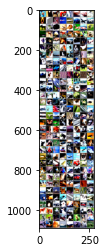

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

I have defined the basic ResNet18 model and added dropout to it



In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         Dropout2d-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        Dropout2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## 3. Define a Loss function and optimizer and train the model

I have used Classification Cross-Entropy loss and SGD with learning rate 0.01 with momentum 0.9.

## 4. Train the model

 I have used 100 epochs to train the model

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []



In [0]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model =  ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=25, gamma=0.1)

EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch, train_losses,train_acc )
    test(model, device, testloader, test_losses, test_acc)
    scheduler.step()

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=1.3323657512664795 Batch_id=195 Accuracy=41.55: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3566, Accuracy: 5150/10000 (51.50%)

EPOCH: 1


Loss=1.0351206064224243 Batch_id=195 Accuracy=58.30: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.0053, Accuracy: 6526/10000 (65.26%)

EPOCH: 2


Loss=0.8604294657707214 Batch_id=195 Accuracy=66.42: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.9065, Accuracy: 7083/10000 (70.83%)

EPOCH: 3


Loss=0.7134209275245667 Batch_id=195 Accuracy=71.31: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7740, Accuracy: 7455/10000 (74.55%)

EPOCH: 4


Loss=0.8940571546554565 Batch_id=195 Accuracy=74.68: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7273, Accuracy: 7540/10000 (75.40%)

EPOCH: 5


Loss=0.5477256178855896 Batch_id=195 Accuracy=77.32: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7602, Accuracy: 7589/10000 (75.89%)

EPOCH: 6


Loss=0.5773938298225403 Batch_id=195 Accuracy=79.51: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5946, Accuracy: 8055/10000 (80.55%)

EPOCH: 7


Loss=0.8579105138778687 Batch_id=195 Accuracy=80.99: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7684, Accuracy: 7829/10000 (78.29%)

EPOCH: 8


Loss=0.3969593346118927 Batch_id=195 Accuracy=82.47: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7226, Accuracy: 7861/10000 (78.61%)

EPOCH: 9


Loss=0.5452821254730225 Batch_id=195 Accuracy=83.65: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7416, Accuracy: 8049/10000 (80.49%)

EPOCH: 10


Loss=0.498792827129364 Batch_id=195 Accuracy=84.34: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6276, Accuracy: 8066/10000 (80.66%)

EPOCH: 11


Loss=0.44105425477027893 Batch_id=195 Accuracy=85.17: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6500, Accuracy: 8130/10000 (81.30%)

EPOCH: 12


Loss=0.43116456270217896 Batch_id=195 Accuracy=85.50: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5691, Accuracy: 8290/10000 (82.90%)

EPOCH: 13


Loss=0.422929584980011 Batch_id=195 Accuracy=86.20: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6373, Accuracy: 8216/10000 (82.16%)

EPOCH: 14


Loss=0.29739436507225037 Batch_id=195 Accuracy=86.09: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6955, Accuracy: 8127/10000 (81.27%)

EPOCH: 15


Loss=0.39879360795021057 Batch_id=195 Accuracy=86.78: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6465, Accuracy: 8290/10000 (82.90%)

EPOCH: 16


Loss=0.5470293760299683 Batch_id=195 Accuracy=86.49: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7225, Accuracy: 8086/10000 (80.86%)

EPOCH: 17


Loss=0.49153628945350647 Batch_id=195 Accuracy=87.32: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6460, Accuracy: 8294/10000 (82.94%)

EPOCH: 18


Loss=0.2976051867008209 Batch_id=195 Accuracy=87.17: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6845, Accuracy: 8343/10000 (83.43%)

EPOCH: 19


Loss=0.26926150918006897 Batch_id=195 Accuracy=87.17: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7168, Accuracy: 8208/10000 (82.08%)

EPOCH: 20


Loss=0.5545051693916321 Batch_id=195 Accuracy=87.62: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7031, Accuracy: 8307/10000 (83.07%)

EPOCH: 21


Loss=0.2511970102787018 Batch_id=195 Accuracy=87.37: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6827, Accuracy: 8318/10000 (83.18%)

EPOCH: 22


Loss=0.2569773197174072 Batch_id=195 Accuracy=87.52: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6453, Accuracy: 8312/10000 (83.12%)

EPOCH: 23


Loss=0.3409900367259979 Batch_id=195 Accuracy=87.71: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6233, Accuracy: 8391/10000 (83.91%)

EPOCH: 24


Loss=0.5218989849090576 Batch_id=195 Accuracy=87.83: 100%|██████████| 196/196 [00:29<00:00,  6.68it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6164, Accuracy: 8351/10000 (83.51%)

EPOCH: 25


Loss=0.2986830770969391 Batch_id=195 Accuracy=88.72: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5106, Accuracy: 8644/10000 (86.44%)

EPOCH: 26


Loss=0.3233480751514435 Batch_id=195 Accuracy=89.16: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5073, Accuracy: 8644/10000 (86.44%)

EPOCH: 27


Loss=0.17116203904151917 Batch_id=195 Accuracy=89.19: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5044, Accuracy: 8667/10000 (86.67%)

EPOCH: 28


Loss=0.299098938703537 Batch_id=195 Accuracy=89.15: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5012, Accuracy: 8670/10000 (86.70%)

EPOCH: 29


Loss=0.5767682790756226 Batch_id=195 Accuracy=89.48: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4979, Accuracy: 8690/10000 (86.90%)

EPOCH: 30


Loss=0.23490819334983826 Batch_id=195 Accuracy=89.57: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4960, Accuracy: 8693/10000 (86.93%)

EPOCH: 31


Loss=0.2356254607439041 Batch_id=195 Accuracy=89.41: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4920, Accuracy: 8684/10000 (86.84%)

EPOCH: 32


Loss=0.2834208607673645 Batch_id=195 Accuracy=89.40: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4920, Accuracy: 8702/10000 (87.02%)

EPOCH: 33


Loss=0.3101917803287506 Batch_id=195 Accuracy=89.41: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4970, Accuracy: 8707/10000 (87.07%)

EPOCH: 34


Loss=0.22381484508514404 Batch_id=195 Accuracy=89.27: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4918, Accuracy: 8704/10000 (87.04%)

EPOCH: 35


Loss=0.14011365175247192 Batch_id=195 Accuracy=89.58: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4966, Accuracy: 8699/10000 (86.99%)

EPOCH: 36


Loss=0.545490562915802 Batch_id=195 Accuracy=89.39: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4955, Accuracy: 8705/10000 (87.05%)

EPOCH: 37


Loss=0.3135144114494324 Batch_id=195 Accuracy=89.77: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4889, Accuracy: 8708/10000 (87.08%)

EPOCH: 38


Loss=0.28099602460861206 Batch_id=195 Accuracy=89.48: 100%|██████████| 196/196 [00:29<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4966, Accuracy: 8700/10000 (87.00%)

EPOCH: 39


Loss=0.19737079739570618 Batch_id=195 Accuracy=89.61: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4931, Accuracy: 8714/10000 (87.14%)

EPOCH: 40


Loss=0.26943978667259216 Batch_id=195 Accuracy=89.31: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4903, Accuracy: 8709/10000 (87.09%)

EPOCH: 41


Loss=0.5349940657615662 Batch_id=195 Accuracy=89.68: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4968, Accuracy: 8715/10000 (87.15%)

EPOCH: 42


Loss=0.2502051889896393 Batch_id=195 Accuracy=89.68: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4891, Accuracy: 8721/10000 (87.21%)

EPOCH: 43


Loss=0.2843869626522064 Batch_id=195 Accuracy=89.77: 100%|██████████| 196/196 [00:29<00:00,  6.64it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4884, Accuracy: 8725/10000 (87.25%)

EPOCH: 44


Loss=0.40765565633773804 Batch_id=195 Accuracy=89.64: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4927, Accuracy: 8714/10000 (87.14%)

EPOCH: 45


Loss=0.3259769678115845 Batch_id=195 Accuracy=89.60: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4943, Accuracy: 8692/10000 (86.92%)

EPOCH: 46


Loss=0.3822272717952728 Batch_id=195 Accuracy=89.79: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4869, Accuracy: 8710/10000 (87.10%)

EPOCH: 47


Loss=0.19201865792274475 Batch_id=195 Accuracy=89.91: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4838, Accuracy: 8721/10000 (87.21%)

EPOCH: 48


Loss=0.25616440176963806 Batch_id=195 Accuracy=89.68: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4923, Accuracy: 8699/10000 (86.99%)

EPOCH: 49


Loss=0.36667346954345703 Batch_id=195 Accuracy=89.59: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4857, Accuracy: 8710/10000 (87.10%)

EPOCH: 50


Loss=0.372732937335968 Batch_id=195 Accuracy=89.96: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4868, Accuracy: 8725/10000 (87.25%)

EPOCH: 51


Loss=0.25900590419769287 Batch_id=195 Accuracy=89.91: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4882, Accuracy: 8711/10000 (87.11%)

EPOCH: 52


Loss=0.4278571605682373 Batch_id=195 Accuracy=90.00: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4877, Accuracy: 8726/10000 (87.26%)

EPOCH: 53


Loss=0.281001478433609 Batch_id=195 Accuracy=89.99: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4834, Accuracy: 8724/10000 (87.24%)

EPOCH: 54


Loss=0.15526893734931946 Batch_id=195 Accuracy=89.96: 100%|██████████| 196/196 [00:29<00:00,  6.69it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4861, Accuracy: 8725/10000 (87.25%)

EPOCH: 55


Loss=0.4202863276004791 Batch_id=195 Accuracy=89.96: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4851, Accuracy: 8728/10000 (87.28%)

EPOCH: 56


Loss=0.35377568006515503 Batch_id=195 Accuracy=89.95: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4842, Accuracy: 8725/10000 (87.25%)

EPOCH: 57


Loss=0.16528072953224182 Batch_id=195 Accuracy=89.75: 100%|██████████| 196/196 [00:29<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4822, Accuracy: 8730/10000 (87.30%)

EPOCH: 58


Loss=0.34941840171813965 Batch_id=195 Accuracy=89.98: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4862, Accuracy: 8710/10000 (87.10%)

EPOCH: 59


Loss=0.2818780839443207 Batch_id=195 Accuracy=90.00: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4871, Accuracy: 8710/10000 (87.10%)

EPOCH: 60


Loss=0.2566755712032318 Batch_id=195 Accuracy=89.82: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4836, Accuracy: 8726/10000 (87.26%)

EPOCH: 61


Loss=0.41818684339523315 Batch_id=195 Accuracy=90.11: 100%|██████████| 196/196 [00:28<00:00,  6.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4860, Accuracy: 8711/10000 (87.11%)

EPOCH: 62


Loss=0.18407496809959412 Batch_id=195 Accuracy=89.74: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4875, Accuracy: 8716/10000 (87.16%)

EPOCH: 63


Loss=0.39072996377944946 Batch_id=195 Accuracy=89.67: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4890, Accuracy: 8720/10000 (87.20%)

EPOCH: 64


Loss=0.27973684668540955 Batch_id=195 Accuracy=89.99: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4854, Accuracy: 8717/10000 (87.17%)

EPOCH: 65


Loss=0.25840091705322266 Batch_id=195 Accuracy=89.71: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4866, Accuracy: 8714/10000 (87.14%)

EPOCH: 66


Loss=0.29757243394851685 Batch_id=195 Accuracy=89.88: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4836, Accuracy: 8725/10000 (87.25%)

EPOCH: 67


Loss=0.38565292954444885 Batch_id=195 Accuracy=89.78: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4817, Accuracy: 8730/10000 (87.30%)

EPOCH: 68


Loss=0.26104164123535156 Batch_id=195 Accuracy=90.08: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4821, Accuracy: 8729/10000 (87.29%)

EPOCH: 69


Loss=0.4543089270591736 Batch_id=195 Accuracy=90.02: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4858, Accuracy: 8708/10000 (87.08%)

EPOCH: 70


Loss=0.22125224769115448 Batch_id=195 Accuracy=89.68: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4818, Accuracy: 8730/10000 (87.30%)

EPOCH: 71


Loss=0.20905068516731262 Batch_id=195 Accuracy=89.72: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4818, Accuracy: 8730/10000 (87.30%)

EPOCH: 72


Loss=0.2191467583179474 Batch_id=195 Accuracy=89.77: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4849, Accuracy: 8726/10000 (87.26%)

EPOCH: 73


Loss=0.361772358417511 Batch_id=195 Accuracy=89.84: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4852, Accuracy: 8724/10000 (87.24%)

EPOCH: 74


Loss=0.33602508902549744 Batch_id=195 Accuracy=89.96: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4873, Accuracy: 8719/10000 (87.19%)

EPOCH: 75


Loss=0.21873979270458221 Batch_id=195 Accuracy=89.74: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4844, Accuracy: 8711/10000 (87.11%)

EPOCH: 76


Loss=0.21943959593772888 Batch_id=195 Accuracy=89.72: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4841, Accuracy: 8725/10000 (87.25%)

EPOCH: 77


Loss=0.46877485513687134 Batch_id=195 Accuracy=89.74: 100%|██████████| 196/196 [00:29<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4807, Accuracy: 8722/10000 (87.22%)

EPOCH: 78


Loss=0.2807096838951111 Batch_id=195 Accuracy=90.23: 100%|██████████| 196/196 [00:29<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4836, Accuracy: 8717/10000 (87.17%)

EPOCH: 79


Loss=0.40569767355918884 Batch_id=195 Accuracy=90.01: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4867, Accuracy: 8710/10000 (87.10%)

EPOCH: 80


Loss=0.2443593442440033 Batch_id=195 Accuracy=90.11: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4835, Accuracy: 8716/10000 (87.16%)

EPOCH: 81


Loss=0.4064207673072815 Batch_id=195 Accuracy=89.96: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4826, Accuracy: 8719/10000 (87.19%)

EPOCH: 82


Loss=0.23720093071460724 Batch_id=195 Accuracy=90.10: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4856, Accuracy: 8728/10000 (87.28%)

EPOCH: 83


Loss=0.2992700934410095 Batch_id=195 Accuracy=89.82: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4838, Accuracy: 8723/10000 (87.23%)

EPOCH: 84


Loss=0.1677267998456955 Batch_id=195 Accuracy=89.86: 100%|██████████| 196/196 [00:29<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4827, Accuracy: 8719/10000 (87.19%)

EPOCH: 85


Loss=0.27543503046035767 Batch_id=195 Accuracy=89.74: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4866, Accuracy: 8723/10000 (87.23%)

EPOCH: 86


Loss=0.30398091673851013 Batch_id=195 Accuracy=89.73: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4840, Accuracy: 8726/10000 (87.26%)

EPOCH: 87


Loss=0.3921108841896057 Batch_id=195 Accuracy=90.00: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4863, Accuracy: 8717/10000 (87.17%)

EPOCH: 88


Loss=0.33565476536750793 Batch_id=195 Accuracy=89.76: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4854, Accuracy: 8739/10000 (87.39%)

EPOCH: 89


Loss=0.33791589736938477 Batch_id=195 Accuracy=89.71: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4861, Accuracy: 8725/10000 (87.25%)

EPOCH: 90


Loss=0.15983571112155914 Batch_id=195 Accuracy=89.93: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4837, Accuracy: 8719/10000 (87.19%)

EPOCH: 91


Loss=0.4244057238101959 Batch_id=195 Accuracy=89.97: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4811, Accuracy: 8728/10000 (87.28%)

EPOCH: 92


Loss=0.33127015829086304 Batch_id=195 Accuracy=90.01: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4844, Accuracy: 8730/10000 (87.30%)

EPOCH: 93


Loss=0.39543986320495605 Batch_id=195 Accuracy=90.01: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4824, Accuracy: 8721/10000 (87.21%)

EPOCH: 94


Loss=0.3485153913497925 Batch_id=195 Accuracy=89.90: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4858, Accuracy: 8726/10000 (87.26%)

EPOCH: 95


Loss=0.31918367743492126 Batch_id=195 Accuracy=90.03: 100%|██████████| 196/196 [00:28<00:00,  6.81it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4883, Accuracy: 8730/10000 (87.30%)

EPOCH: 96


Loss=0.1598966121673584 Batch_id=195 Accuracy=89.77: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4831, Accuracy: 8727/10000 (87.27%)

EPOCH: 97


Loss=0.430976927280426 Batch_id=195 Accuracy=90.10: 100%|██████████| 196/196 [00:28<00:00,  6.81it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4852, Accuracy: 8716/10000 (87.16%)

EPOCH: 98


Loss=0.2059617042541504 Batch_id=195 Accuracy=89.87: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4859, Accuracy: 8719/10000 (87.19%)

EPOCH: 99


Loss=0.2799977958202362 Batch_id=195 Accuracy=90.02: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]



Test set: Average loss: 0.4844, Accuracy: 8725/10000 (87.25%)



## Save the Model

In [0]:
import os

PATH = '/content/drive/My Drive/cifar10_resnet18_new.pth'
torch.save(model.state_dict(), PATH)

## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


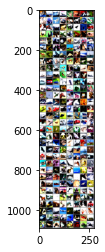

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of the network on the 10000 test images: 87.25 %


The accuracy 87.25 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of plane : 93 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 54 %
Accuracy of  deer : 92 %
Accuracy of   dog : 80 %
Accuracy of  frog : 72 %
Accuracy of horse : 100 %
Accuracy of  ship : 90 %
Accuracy of truck : 82 %


## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Loss
ii. Training Accuracy
iii. Test Loss
iv. Test Accuracy

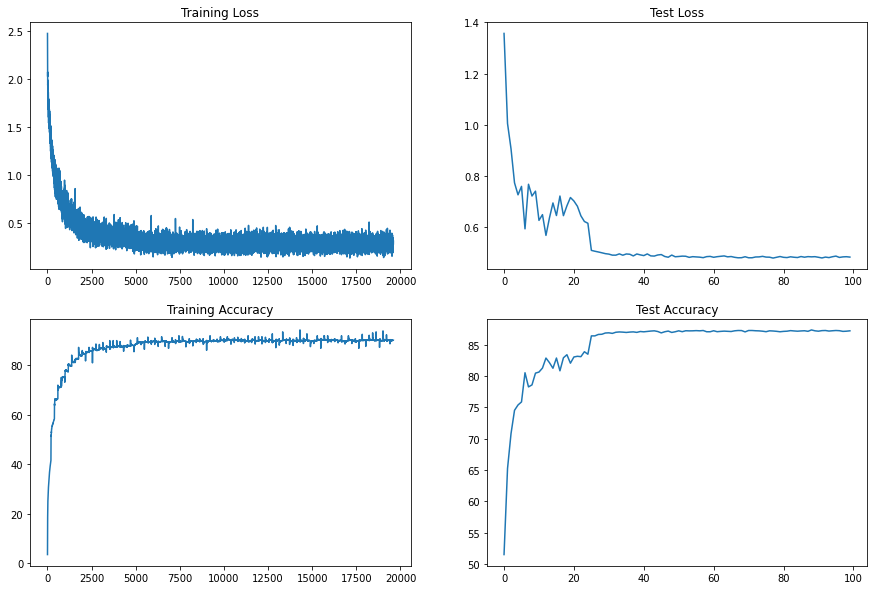

In [0]:
plot_loss_accuracy(train_losses, train_acc, test_losses, test_acc)

## Display Misclassified Images

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for im

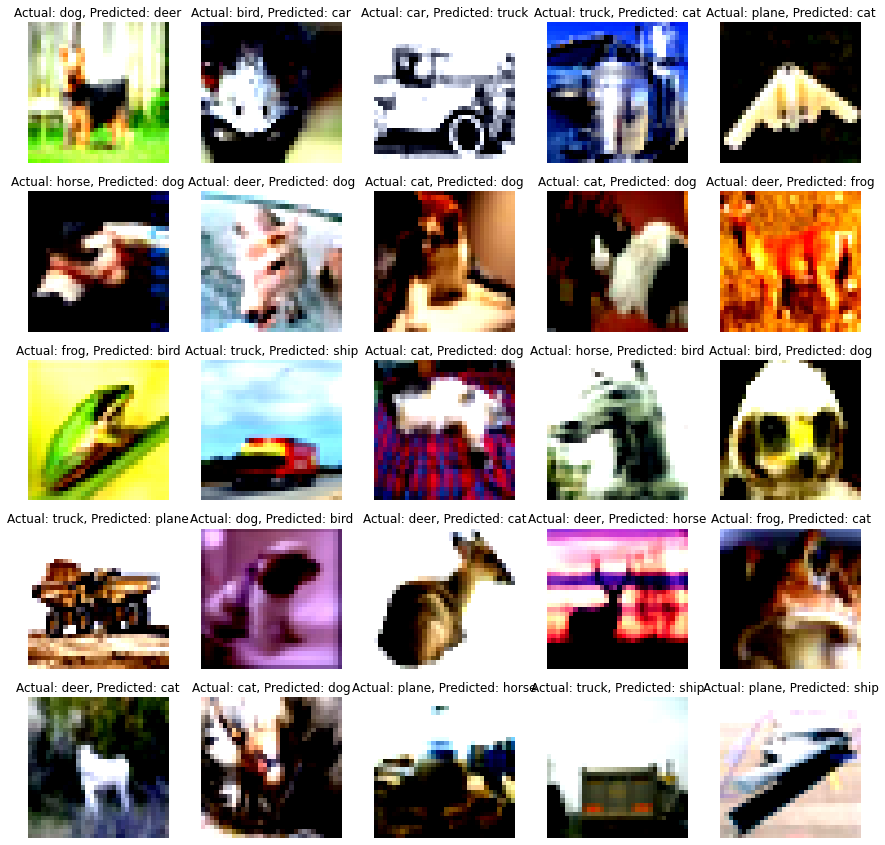

In [0]:
display_misclassfied_ciphar10_images(testloader, model, device, classes, 25)